# Deep and Cross Network
## Pytorch implementation based on the paper arxiv.org/abs/1708.05123

In [1]:
import yaml
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim
import torch.onnx
import numpy as np
from sklearn.metrics import roc_auc_score
import os
import time
from torchvision.transforms import *
from tqdm import tqdm, tqdm_notebook, tnrange
import matplotlib.pyplot as plt

SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

%matplotlib inline

In [2]:
with open("data_config.yml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
filename = cfg['filename']
x_col_cat = cfg['features']['categorical']
x_col_con = cfg['features']['continuous']
y_col = cfg['features']['label']
w_col = cfg['features']['weight']

In [3]:
nrows=1e6
df = pd.read_csv(filename, nrows=nrows)
print("dataset size: %s"%str(df.shape))
print("ctr = %.5f"%((df[y_col]*df[w_col]).sum()*1./df[w_col].sum()))

dataset size: (1000000, 67)
ctr = 0.00980


In [4]:
def merge_2_cols(arr):
    arr = arr.astype(str)
    vals = (arr[:,0].astype(object)+'_'+arr[:,1].astype(object))
    return vals

In [5]:
cat_features =[]
for f in x_col_cat:
    if(isinstance(f, str)==False):
        df[list(f.keys())[0]] = merge_2_cols(df[list(f.values())[0]].values)
        cat_features.append(list(f.keys())[0])
    else:
        cat_features.append(f)

### Encoding

In [6]:
def binary_encode(s, modulo, required_bits=8):
    num = hash(s) % modulo
    return np.array(list(np.binary_repr(num).zfill(required_bits))).astype(np.int8)

def hashing_trick(s, modulo):
    num = hash(s) % modulo
    arr = np.zeros((modulo)).astype(np.int8)
    arr[num] = 1
    return arr

def get_sparse_index(s, modulo):
    return hash(s) % modulo

Combine columns

In [7]:
df = df[cat_features + x_col_con + [y_col] + [w_col]]

Here we represent categorical features as sparse index. In production system this encoding can be done by maintaining a map of unique values per feature. A Bloom filter can be used to track each value on the fly by checking whether a specific value exists and update the counters accordingly

In [8]:
b_x_col_cat = []
logs = []
modulos = []
for col in tqdm(cat_features):
    bits = int(np.ceil(np.log2(df[col].nunique())))
    modulos.append(df[col].nunique()+1)
    b_x_col_cat.append('b_'+col)
    df[b_x_col_cat[-1]] = df[col].apply(get_sparse_index, modulo=modulos[-1])#, required_bits=bits)
df.drop(columns=cat_features, inplace=True)

100%|██████████| 4/4 [00:02<00:00,  1.36it/s]


In [9]:
x_cols = [c for c in df.columns if (c != 'clicks') and (c != 'impressions')]

In [10]:
x_dense = np.array(df[x_cols[:4]])
x_sparse = np.array(df[x_cols[4:]])
x = np.concatenate([x_dense, x_sparse], axis=1)
y, w = np.array(df[y_col]), np.array(df[w_col])
print("x_dense: %s x_sparse: %s y: %s w: %s"%(x_dense.shape, x_sparse.shape, y.shape, w.shape))
del df

x_dense: (1000000, 4) x_sparse: (1000000, 4) y: (1000000,) w: (1000000,)


### Prepare data for pytorch and split

In [11]:
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
w = torch.FloatTensor(w)

In [12]:
n, m = x.shape
randvec = torch.randperm(n)
x_train, x_val = torch.split(x[randvec],(n*3)//5, 0)
y_train, y_val = torch.split(y[randvec],(n*3)//5, 0)
w_train, w_val = torch.split(w[randvec],(n*3)//5, 0)

print("num obs train %d\nnum obs val %d"%(x_train.shape[0], x_val.shape[0]))

num obs train 600000
num obs val 400000


In [13]:
x_train = Variable(x_train)
x_val = Variable(x_val)
y_train = Variable(y_train)
y_val = Variable(y_val)

## Build Model

### Define Hyperparameters

In [14]:
m_embed = 10
units = 200
dense_col = torch.LongTensor(list(range(0, 4)))
sparse_col = torch.LongTensor(list(range(4, m)))
m_sparse = sparse_col.size()[0]
m_dense = dense_col.size()[0]

### Define Network layers

In [15]:
class fullDCN(nn.Module):
    def __init__(self, embedding_sizes):
        super().__init__()
        self.embedding_layers = nn.ModuleList()
        for embed_size in embedding_sizes:
            self.embedding_layers.append(nn.Embedding(embed_size, m_embed))
        cross_layer_size = m_dense+(m_embed*m_sparse)
        #deep network layers
        self.fc1 = nn.Linear(cross_layer_size, units, bias=True)
        self.fc1_bn = nn.BatchNorm1d(units)
        self.fc2 = nn.Linear(units, units, bias=True)
        self.fc2_bn = nn.BatchNorm1d(units)
        self.fc3 = nn.Linear(units, units, bias=True)
        #cross network layers
        self.cl1 = nn.Linear(cross_layer_size, cross_layer_size, bias=True)
        self.cl1_bn = nn.BatchNorm1d(cross_layer_size)
        self.cl2 = nn.Linear(cross_layer_size, cross_layer_size, bias=True)
        self.cl2_bn = nn.BatchNorm1d(cross_layer_size)
        self.cl3 = nn.Linear(cross_layer_size, cross_layer_size, bias=True)
        #combination layer
        self.CombLayer = nn.Linear(units+cross_layer_size, 1, bias=False)
        #output
        self.output = nn.Sigmoid()

    def forward(self, x):
        x_sparse = x[:,sparse_col].long()
        x_dense = x[:,dense_col]
        for sparse_feature in range(m_sparse):
            new_embed = self.embedding_layers[sparse_feature](x_sparse[:, sparse_feature])
            if(sparse_feature==0):
                x_embed = new_embed
            else:
                x_embed = torch.cat([x_embed, new_embed], dim=1)
        x0 = torch.cat([x_embed, x_dense], dim=1)
        
        x = F.relu(self.fc1_bn(self.fc1(x0)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = F.relu(self.fc3(x))
        
        x_l1 = self.cl1(x0)
        x1 = x0 * x_l1 + x0
        x_l2 = self.cl2(x1)
        x2 = x0 * x_l2 + x1
        x_l3 = self.cl3(x1)
        x3 = x0 * x_l3 + x2
        
        x_final = torch.cat([x, x3], dim=1)
        result = self.CombLayer(x_final)
        y = self.output(result)
        return y

### Define Model parameters

In [26]:
DCNnet = fullDCN(modulos)
print(DCNnet)

fullDCN(
  (embedding_layers): ModuleList(
    (0): Embedding(12, 10)
    (1): Embedding(19, 10)
    (2): Embedding(46, 10)
    (3): Embedding(121, 10)
  )
  (fc1): Linear(in_features=44, out_features=200, bias=True)
  (fc1_bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc2_bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=200, out_features=200, bias=True)
  (cl1): Linear(in_features=44, out_features=44, bias=True)
  (cl1_bn): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cl2): Linear(in_features=44, out_features=44, bias=True)
  (cl2_bn): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cl3): Linear(in_features=44, out_features=44, bias=True)
  (CombLayer): Linear(in_features=244, out_features=1, bias=False)
  (output): Sigmoid()
)


In [31]:
criterion = nn.BCELoss()
optimizer = optim.Adam(DCNnet.parameters(), lr=.001)
# optimizer = torch.optim.SGD(DCNnet.parameters(), lr=0.01, momentum=1.2)
epochs = 2
batch_size = 2**17
num_batches = int(len(y_train)//batch_size)
print("Model parameters:")
print("criterion:\n%s"%str(criterion))
print("optimizer:\n%s"%str(optimizer))
print("epochs: %d"%epochs)
print("batch_size: %d"%batch_size)
print("num_batches: %d"%num_batches)

Model parameters:
criterion:
BCELoss()
optimizer:
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
epochs: 2
batch_size: 131072
num_batches: 4


## Run the model

In [32]:
train_loss = 0
val_loss = 0
scale = 10e5
mean_val_loss, val_auc, val_cal = [], [], []
for t in range(epochs):
    epochrandvec=torch.randperm(len(y_train))
    x_train = x_train[epochrandvec,:]
    y_train = y_train[epochrandvec]
    w_train = w_train[epochrandvec]
    
    for i in range(num_batches):
        start_time = time.time()
        indvec = torch.LongTensor(list(range((i)*batch_size, (i)*batch_size+batch_size)))
        x_batch = x_train[indvec]
        y_batch = y_train[indvec]
        criterion.weight = w_train[indvec]
        
        x_sparse = x_batch[:,sparse_col]
        x_dense = x_batch[:,dense_col]

        #initialize
        optimizer.zero_grad()
        
        # forward + backward + optimize
        trainOutputs = DCNnet(x_batch)
        loss = criterion(trainOutputs.squeeze(), y_batch)
        train_loss = scale*loss.item()
        
        #Update Network
        loss.backward()
        optimizer.step()

        #evaluation metrics
        valOutputs = DCNnet(x_val)
        criterion.weight = w_val
        val_loss += scale*criterion(valOutputs.squeeze(), y_val).item()
        mean_val_loss.append(val_loss/((i+1+t*num_batches)*x_val.shape[0]))
        val_auc.append(roc_auc_score(y_val.data.numpy(), valOutputs.data.numpy(), sample_weight=w_val))
        val_cal.append((valOutputs.squeeze().mul(w_val).sum() / y_val.mul(w_val).sum()).item())
        
        end_time = time.time()
        elapsed = end_time - start_time
        print("e: %2d/%2d, b: %2d/%2d, tr_loss=%.3f, val_loss=%.3f, auc=%.3f, cal=%.3f, %.2fs"%
              (t+1, epochs, i+1, num_batches, 
               train_loss/(batch_size*(i+1+t*num_batches)), mean_val_loss[-1], 
               val_auc[-1], val_cal[-1], elapsed))
    
print('Finished Training')

e:  1/ 2, b:  1/ 4, tr_loss=2.930, val_loss=0.759, auc=0.593, cal=13.386, 10.28s
e:  1/ 2, b:  2/ 4, tr_loss=1.155, val_loss=0.681, auc=0.606, cal=10.215, 10.15s
e:  1/ 2, b:  3/ 4, tr_loss=0.613, val_loss=0.617, auc=0.622, cal=7.704, 10.12s
e:  1/ 2, b:  4/ 4, tr_loss=0.369, val_loss=0.564, auc=0.637, cal=5.762, 10.08s
e:  2/ 2, b:  1/ 4, tr_loss=0.245, val_loss=0.520, auc=0.654, cal=4.286, 10.81s
e:  2/ 2, b:  2/ 4, tr_loss=0.175, val_loss=0.484, auc=0.675, cal=3.199, 10.68s
e:  2/ 2, b:  3/ 4, tr_loss=0.132, val_loss=0.454, auc=0.697, cal=2.412, 10.52s
e:  2/ 2, b:  4/ 4, tr_loss=0.104, val_loss=0.430, auc=0.717, cal=1.854, 10.13s
Finished Training


## Calculate AUC and calibration metrics

In [33]:
for data in [[x_train, y_train, w_train, 'train'], [x_val, y_val, w_val, 'val']]:
    probs = DCNnet(data[0]).squeeze()
    sample_weight = data[2].data.numpy()
    print(data[3]+':')
    print("number of observations = %d"%(len(data[1].data.numpy())))
    print("\tAUC = %.4f"%(roc_auc_score(data[1].data.numpy(), probs.data.numpy(), sample_weight=sample_weight)))
    print("\tCalibration = %.4f"%((probs.mul(data[2]).sum()/data[1].mul(data[2]).sum()).item()))
    print("\tctrpm = %.2f"%(1000*data[1].mul(data[2]).sum()/data[1].mul(data[2]).shape[0]))

train:
number of observations = 600000
	AUC = 0.7157
	Calibration = 1.8829
	ctrpm = 18.23
val:
number of observations = 400000
	AUC = 0.7170
	Calibration = 1.8540
	ctrpm = 18.59


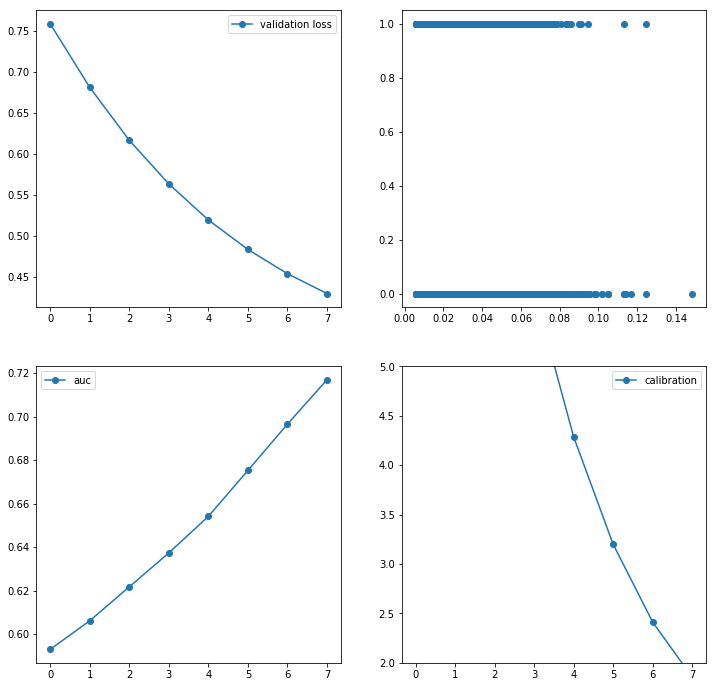

In [34]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(mean_val_loss, label='validation loss', marker='o')
plt.legend()
plt.subplot(2,2,2)
plt.plot(probs.data.numpy(), y_val.data.numpy(), 'o')
plt.subplot(2,2,3)
plt.plot(val_auc, 'o-', label='auc')
plt.legend()
plt.subplot(2,2,4)
plt.plot(val_cal, 'o-', label='calibration')
plt.ylim([2,5])
plt.legend()

## Export model with onnx

In [ ]:
from tensorboardX import SummaryWriter

# writer = SummaryWriter(comment='testing')
# writer.add_graph(DCNnet, , verbose=False)
dummy_input = x_val
torch.onnx.export(DCNnet, dummy_input, 'dcnet.onnx', verbose=False)